<a target="_blank" href="https://colab.research.google.com/github/davalpez/MyKaggle/blob/MyKaggle/Tensorflow%20basics/TF-transfer_learning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Transfer Learning : Part 2

In the previous notebook, we tried different experiments based on different approach to try our modified CNN based on efficientnet and comparing its results to the official baseline of the Food-101 dataset, a classification model based on random forest, to see how well could our CNN perform on a similar setup.


We will try to add more classes from the original dataset, trying to achieve the best results possible with all the classes but just a 10% of its training images.

Let's start confirming our GPU is on and available, import the datadet and create our first model for the amplified data.

In [7]:
!nvidia-smi

Thu Feb 20 14:33:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.51                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   87C    P3             37W /   92W |    6411MiB /   8192MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
# Import tensorflow and confirm the GPU availability.
import tensorflow as tf
tf.config.set_soft_device_placement(True)
print(tf.config.list_physical_devices('GPU'))

2025-02-20 14:33:34.291623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740054814.531302     712 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740054814.591703     712 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 14:33:35.079760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We will also import our modelgraph file, where we store some common function we use in this notebooks and use the reload function from the library importlib.

In [2]:
import sys
import os

sys.path.append(os.path.abspath("../lib"))

In [91]:
import importlib
import modelgraph  # Import the module
importlib.reload(modelgraph)  # Reload it after changes

<module 'modelgraph' from '/home/david/VSpython/Git/lib/modelgraph.py'>

## Importing the data, creating dataset

We have downloaded the dataset from [Kaggle Food-101](https://www.kaggle.com/datasets/dansbecker/food-101). We have created different datasets in the previous notebook to experiment and scale up slowly our results. We have noticed that data augmentation helped a lot to our results. So let's first import the data and then draft a plan to our future experiments.

We have an average of 75 images per class in the training directory and 250 images in our testing directory.

In [4]:
basedir = "../Sources/Food-101-full-10p/"
modelgraph.ImagesInDir(basedir)

 2 Directories and 0 images in '../Sources/Food-101-full-10p/'.
 101 Directories and 0 images in '../Sources/Food-101-full-10p/test'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/beignets'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/beef_carpaccio'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/mussels'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/french_fries'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/club_sandwich'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/onion_rings'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/lasagna'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/pizza'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/bruschetta'.
 0 Directories and 250 images in '../Sources/Food-101-full-10p/test/macaroni_and_cheese'.
 0 Directories and 250 images in '../Sources/Food-

Let's then create the dataset for training and testing : 

In [5]:
# Define directory path
training_full_10p = basedir +  "train"
testing_full_10p  = basedir +  "test"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create datasets
train_10p_dataset = tf.keras.preprocessing.image_dataset_from_directory(training_full_10p,
                                               batch_size=BATCH_SIZE, # number of images to process at a time 
                                               image_size=IMAGE_SIZE,# resize image to the designated value
                                               label_mode="categorical", # only working witht two labels
                                               shuffle=True, # mixes images from both folders.
                                               seed=10)

test_10p_dataset = tf.keras.preprocessing.image_dataset_from_directory(testing_full_10p,
                                               batch_size=BATCH_SIZE, # number of images to process at a time 
                                               image_size=IMAGE_SIZE, # resize image to the designated value
                                               label_mode="categorical", # only working witht two labels
                                               shuffle=True, # mixes images from both folders.
                                               seed=10)

Found 7575 files belonging to 101 classes.


I0000 00:00:1740054830.214370     712 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 25250 files belonging to 101 classes.


In [109]:
class_names = test_10p_dataset.class_names

## Draft a plan for the experiment

Now that we have the classes, we want to think what are the following steps we are going to follow to build the model and why we are going to use them.

1. We want to add `data augmentation` layer as we did in our previous experiments as it improves the accuracy of the model by allowing it to obtain better the featured characteristics of each class.

2. We want to have `checkpoint callback` if we want to have our model working at a certain epoch or just retake it at that point for continuing training later on.

3. We want to continue using a model which uses an application model at its core, in this case `efficientnetv2b0`.

4. Continue doing 5 epochs and quick tests by using only 25% for checking the validation accuracy before doing a total evaluation.

Let's prepare then data augmentation pack and checkpoint callback and then build our model.

In [6]:
from tensorflow.keras.layers import Rescaling,RandomFlip,RandomRotation,RandomZoom

data_augmented_layer_pack = tf.keras.models.Sequential([
     #Augmented feed
     RandomFlip("horizontal_and_vertical"),
     RandomZoom(0.2),
     RandomRotation(0.2)])

In [7]:

# Setup checkpoint path
checkpoint_path = "/tmp/ckpt/checkpoints/checkpoint.model.weights.h5" 

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

## Building our model

Let's fetch the function we used in our first transfer learning notebook to create TF models as we can quickly expand our experiment in our notebook later on.

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Input
from tensorflow.keras import Model

def CreateTransferLearningModel(trainable=False,TrainableLayers=0,class_number=101):
    ''' Creates a model using transfer learning model by introducing some defining parameters
    Args:
    Trainable: Determines if there are any layers trainable from the core model efficientnet.
    class_number: Number of classes expected for the output layer.
    Returns:
    model : keras.model prepared that needs to be compiled and fit.
    
    '''
    # Create inputs
    
    inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

    # Create application based model
    application_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    application_model.trainable = False

    # Setup n layersif trainable
    if trainable == True:
        print("These layers will be trainable now : ")
        for layer_number,layer in  enumerate(application_model.layers[-TrainableLayers:]):
            layer.trainable = True
            print(layer_number,layer.name, layer.trainable)

    # Setup model input and outputs with data augmentation built-in
    x = data_augmented_layer_pack(inputs)
    x = application_model(x)  # pass augmented images to base model but keep it in inference mode
    x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = Dense(units=class_number, activation="softmax", name="output_layer")(x)
    model = Model(inputs, outputs)

    return model

Now we can start. Our first model for this section is going to have the base application model as is, with all the layers frozen.

1. Create model

In [30]:
model_0_10p = CreateTransferLearningModel()

2. Compile the model

In [31]:
# 2. Compile the model

from tensorflow.keras.optimizers import Adam

model_0_10p.compile(loss="categorical_crossentropy",
              optimizer= Adam(),
              metrics=["accuracy"])

3. Fit the model

In [32]:
# 3.  Fit the model
history_model_0_10p = model_0_10p.fit(train_10p_dataset,
                    epochs=5,
                    steps_per_epoch=len(train_10p_dataset),
                    validation_data=test_10p_dataset,
                    validation_steps=int(0.25* len(test_10p_dataset)), 
                    )

Epoch 1/5


E0000 00:00:1739872851.329410    4944 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1739872853.862766  353447 cuda_dnn.cc:529] Loaded cuDNN version 90300


237/237 ━━━━━━━━━━━━━━━━━━━━ 65s 217ms/step - accuracy: 0.1329 - loss: 4.0873 - val_accuracy: 0.4342 - val_loss: 2.5510
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 211ms/step - accuracy: 0.4105 - loss: 2.5787 - val_accuracy: 0.5133 - val_loss: 2.0383
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 229ms/step - accuracy: 0.4981 - loss: 2.1363 - val_accuracy: 0.5349 - val_loss: 1.8364
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 76s 323ms/step - accuracy: 0.5394 - loss: 1.9221 - val_accuracy: 0.5508 - val_loss: 1.7252
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 85s 358ms/step - accuracy: 0.5651 - loss: 1.7887 - val_accuracy: 0.5658 - val_loss: 1.6574


In [33]:
results_feature_extraction_model = model_0_10p.evaluate(test_10p_dataset)

790/790 ━━━━━━━━━━━━━━━━━━━━ 91s 115ms/step - accuracy: 0.5606 - loss: 1.6737


[The original Random Forest model that was used for this dataset (50.76%)](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), and it also marks that the top performing method for average accuracy was a CNN for 56.40%. We already have outperformed, for a bit, all the methods in this paper (Counting we are making a CNN as well.) Comparison is that the CNN architecture was more simple, made outof only eight learned layers —five convolutional and three fully-connected. Quite an achivement!

Let's see how the curves look.

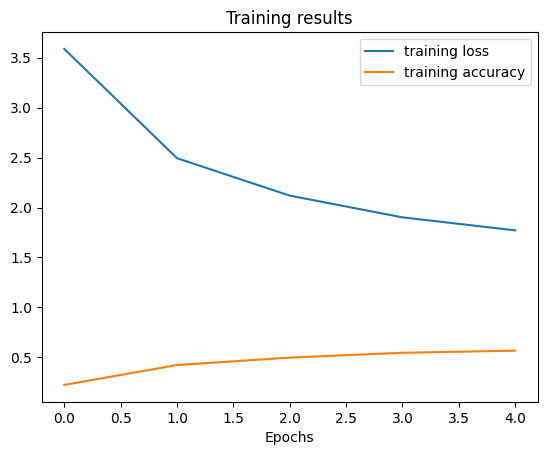

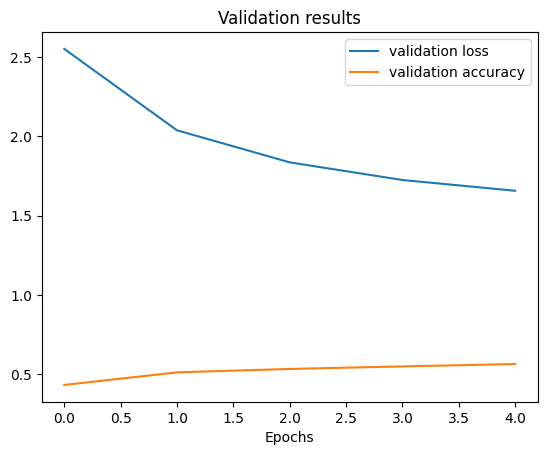

In [34]:
modelgraph.PlotAccuracyAndLoss(history_model_0_10p)

Let's try to do some fine tuning and compare again the curve to get better conclusions.

## Fine-tuning our model

To improve the performance of our CNN, we will try now to unfreeze as we did in TF-transfer_learning and let the model learn more details of the new dataset we are introducing. We could see from the curves that the model was a bit rigid and not learning as much as it did before. This could be because now, there are many more features it should try to learn to identify all the 101 classes compare to just the 11 we had before.

In [35]:
model_0_10p.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,307,457 (24.06 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 258,764 (1010.80 KB)

The application model is the second layer[2] of our model.

In [37]:
application_model_10p = model_0_10p.layers[2]
application_model_10p.name

'efficientnetv2-b0'

Let's do the last 5 layers trainable.

In [38]:
for layer_number,layer in  enumerate(application_model_10p.layers[-5:]):
    layer.trainable = True
    print(layer_number,layer.name, layer.trainable)

0 block6h_drop True
1 block6h_add True
2 top_conv True
3 top_bn True
4 top_activation True


In [39]:
model_0_10p.summary() 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,307,457 (24.06 MB)

 Trainable params: 377,701 (1.44 MB)

 Non-trainable params: 5,670,992 (21.63 MB)

 Optimizer params: 258,764 (1010.80 KB)

We can confirm now we have 377,701 trainable parameters compared to 129,381 from before.
Now we recompile the model : 

In [40]:
# 2. Recompile the model

model_0_10p.compile(loss="categorical_crossentropy",
              optimizer= Adam(),
              metrics=["accuracy"])

Let's now train for fine-tuning

In [41]:
# 3. Fit the model
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_model_0_10p_ft = model_0_10p.fit(train_10p_dataset,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_10p_dataset,
                                                     validation_steps=int(0.15 * len(test_10p_dataset)), # validate on 15% of the test data
                                                     initial_epoch=history_model_0_10p.epoch[-1]) # start from previous last epoch
     

Epoch 5/10


E0000 00:00:1739883011.323846    4944 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


237/237 ━━━━━━━━━━━━━━━━━━━━ 58s 167ms/step - accuracy: 0.5577 - loss: 1.8493 - val_accuracy: 0.5800 - val_loss: 1.5414
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - accuracy: 0.6320 - loss: 1.4530 - val_accuracy: 0.5967 - val_loss: 1.5010
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.6700 - loss: 1.2642 - val_accuracy: 0.6115 - val_loss: 1.4641
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.6975 - loss: 1.1400 - val_accuracy: 0.6147 - val_loss: 1.4433
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 46s 193ms/step - accuracy: 0.7254 - loss: 1.0346 - val_accuracy: 0.6253 - val_loss: 1.4628
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 49s 208ms/step - accuracy: 0.7486 - loss: 0.9274 - val_accuracy: 0.6255 - val_loss: 1.4525


In [42]:
results_feature_extraction_model_ft = model_0_10p.evaluate(test_10p_dataset)

790/790 ━━━━━━━━━━━━━━━━━━━━ 108s 136ms/step - accuracy: 0.6221 - loss: 1.4397


In [44]:
#Previously...
results_feature_extraction_model

[1.6714612245559692, 0.5642375946044922]

Our model has improved, we could go even further to improve these results. Let's still check for now how the curves look after the fine-tuning:

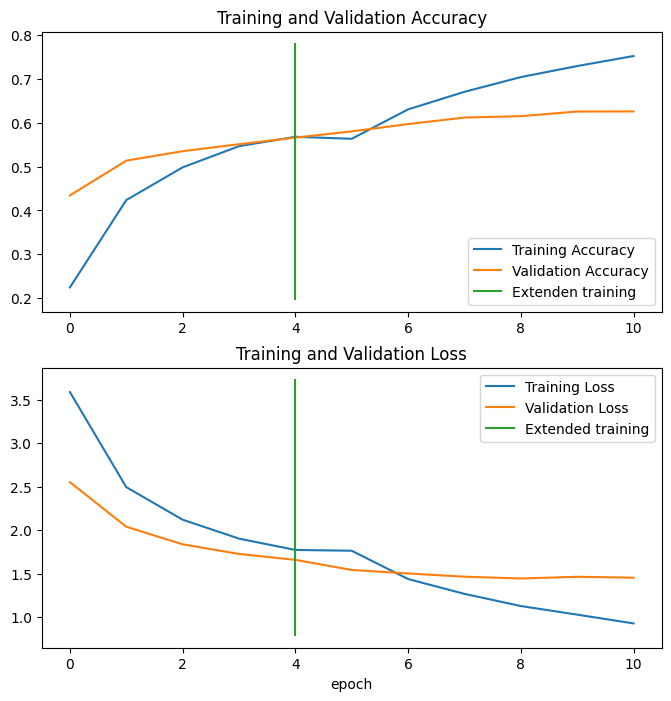

In [45]:
modelgraph.PlotAccuracyAndLossExtended(history_model_0_10p,history_model_0_10p_ft,5)

As we see the curves crossing, this could mean that the model is learning well the training data but is failing to classify new data that sees during the validation stage.

Having a checkpoint here, so let's save and load when continuing as these models are starting to get more time to get trained:

In [59]:
model_0_10p.save('saved_models/model_10p_EfficientNetV2B0.keras')

## Evaluating the performance

First, let's load back our model to continue using it as we left it. Let's confirm the model loaded correctly and do an evaluation again.

In [8]:
import tensorflow as tf
model_0_10p = tf.keras.models.load_model('saved_models/model_10p_EfficientNetV2B0.keras') 

In [9]:
model_0_10p.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,804,097 (25.96 MB)

 Trainable params: 377,701 (1.44 MB)

 Non-trainable params: 5,670,992 (21.63 MB)

 Optimizer params: 755,404 (2.88 MB)

The model seems to have loaded correclty.

When we [**evaluate**](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) our model, we obtain the loss value & metrics values for the model in test mode.

When we [**predict**](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), we only generate a prediction for the given input data, there is no meassuring of accuracy or loss.

Doing a first evaluation :

In [10]:
results_feature_extraction_model_ft = model_0_10p.evaluate(test_10p_dataset)

I0000 00:00:1740054860.200348     931 cuda_dnn.cc:529] Loaded cuDNN version 90300


790/790 ━━━━━━━━━━━━━━━━━━━━ 190s 227ms/step - accuracy: 0.6218 - loss: 1.4411


Doing now a prediction to see how our model interacts with the data:

This is a good view to what our model sees and how interprets the data. We still can go further an analyze in detail what the model is classifying on a broader range. As we have done before in our TF-multiclass, we can build a confusion matrix to see how well the model predicts each class and what are the main erros our model produces. 

In [13]:
pred_probs = model_0_10p.predict(test_10p_dataset, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 82ms/step


We have in our test directory 101 dirs, each one with 250 images. So we should have 25250 predictions.

In [14]:
len(pred_probs)

25250

As we have one hot encoding, our probabilities should refer the probabilities of being the different 101 classes.

In [15]:
pred_probs.shape

(25250, 101)

Let's take a look of a random image prediction. Most of the classes have very low chances of being the right prediction, and we can see a few of them that have a magnitue close to 1.e-+1, meaning it has great tendency for a close prediction. Still, we would like our model to perform better than 60% accuracy.

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample n15: {len(pred_probs[15])}")
print(f"What prediction probability sample n15 looks like:\n {pred_probs[15]}")
print(f"The class with the highest predicted probability by the model for sample n15: {pred_probs[15].argmax()}")
print(f"Which is the class for : {class_names[pred_probs[15].argmax()] }")


Number of prediction probabilities for sample n15: 101
What prediction probability sample n15 looks like:
 [1.03180115e-04 3.75724397e-07 3.55692407e-07 3.89534138e-09
 2.81084453e-06 4.03997831e-07 3.06738627e-07 2.11362731e-05
 1.70654948e-05 1.93589517e-06 2.94069018e-08 1.60122042e-07
 7.64213226e-08 1.86422028e-07 1.13797105e-05 1.60451396e-04
 9.60007398e-08 3.40840330e-07 6.18038612e-05 2.18086552e-06
 1.61647004e-05 9.85515271e-07 1.74118017e-04 6.29165982e-07
 7.19799937e-06 1.47710057e-06 1.57166451e-05 1.25897225e-06
 5.32611884e-05 7.56017631e-04 1.46991965e-06 3.15490638e-06
 9.70574038e-05 3.14453708e-08 1.32661880e-04 6.21733331e-09
 2.84053544e-06 3.90735186e-05 1.58470120e-05 1.12155929e-08
 4.71041603e-05 1.47166384e-05 1.96692199e-07 2.86991199e-05
 4.82699943e-06 7.04515586e-03 1.02523956e-07 1.81519582e-07
 2.15825503e-06 7.14269254e-06 5.02233028e-08 6.96670713e-06
 3.29139516e-06 4.96542896e-04 1.70251564e-08 9.85391239e-07
 4.01218222e-06 2.03628269e-06 9.873988

The way the softmax generates the predictions is that the sum of all the predictions should be 1 or very close to one.

In [17]:
pred_probs[0].sum()

np.float32(1.0)

In our predict function, we take batches where we get the images and labels and that is how we present the images with a correct(green) or failed(red)prediction. If we want to know how correct our predictions are from the whole dataset, we need to unbatch first the testing dataset.

In [18]:
y_labels = []
for images, labels in test_10p_dataset.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

2025-02-20 14:57:07.197886: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[np.int64(84),
 np.int64(88),
 np.int64(25),
 np.int64(29),
 np.int64(93),
 np.int64(51),
 np.int64(40),
 np.int64(77),
 np.int64(42),
 np.int64(65)]

If we check the first 10 predictions:

In [19]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([70, 28, 13, 41,  2, 33,  3, 26, 37, 80])

In [20]:
for i in range(len(pred_classes[:10])):
    match = "Correct" if pred_classes[i]==y_labels[i] else "Wrong"
    print(i,match)

0 Wrong
1 Wrong
2 Wrong
3 Wrong
4 Wrong
5 Wrong
6 Wrong
7 Wrong
8 Wrong
9 Wrong


We are having a problem here because our test dataset is **shuffled**, so the order of the labels of the predictions does not match the ones from when we unraveled the dataset later. Let's quickly make another unshuffled dataset, make the prediction and compare again.

In [21]:
# Unshuffled dataset
test_10p_dataset_unshuffled = tf.keras.preprocessing.image_dataset_from_directory(testing_full_10p,
                                               batch_size=BATCH_SIZE, # number of images to process at a time 
                                               image_size=IMAGE_SIZE, # resize image to the designated value
                                               label_mode="categorical", # only working witht two labels
                                               shuffle=False, # mixes images from both folders.
                                               seed=10)

Found 25250 files belonging to 101 classes.


In [22]:
# Unbatch and obtain original labels
y_labels_unshuffled = []
for images, labels in test_10p_dataset_unshuffled.unbatch(): 
  y_labels_unshuffled.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels_unshuffled[:10] # check what they look like (unshuffled)

2025-02-20 14:57:23.671694: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [23]:
# Obtain predictions from the new unshuffled dataset
pred_probs_unshuffled = model_0_10p.predict(test_10p_dataset_unshuffled, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 74s 93ms/step


In [24]:
# Get the class predicitons of each label
pred_classes_unshuffled = pred_probs_unshuffled.argmax(axis=1)

In [25]:
# Review correct predictions
for i in range(len(pred_classes_unshuffled[:15])):
    match = "Correct" if pred_classes_unshuffled[i]==y_labels_unshuffled[i] else "Wrong"
    print(i,match)

0 Wrong
1 Correct
2 Correct
3 Wrong
4 Wrong
5 Wrong
6 Wrong
7 Wrong
8 Correct
9 Correct
10 Correct
11 Wrong
12 Wrong
13 Wrong
14 Wrong


This looks more logical. Also it seems that with the first class the model is not doing so great :(
Confirming we have the same amount of predictions and labels :

In [26]:
len(pred_classes_unshuffled),len(y_labels_unshuffled)

(25250, 25250)

We can now evaluate our predictions.

## Evaluating our model's predictions

Sometimes we have good functions from Scikit-learn library that help us to evaluate or prepare datasets in a more effective way. This time, we will use `accuracy_score` to see how our predictions performed.

In [27]:

# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels_unshuffled, pred_classes_unshuffled)
sklearn_accuracy

0.6231683168316832

In [28]:
loaded_loss, loaded_accuracy = model_0_10p.evaluate(test_10p_dataset_unshuffled)

790/790 ━━━━━━━━━━━━━━━━━━━━ 104s 132ms/step - accuracy: 0.6072 - loss: 1.5013


In [29]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")
     

Close? True | Difference: -2.7170275695986845e-08


We re-loaded our modelgraph library as we included the previously used `PlotConfusionMatrix`. The first plotting was very cramped as, compared to the predictions we did back then, the number of classes has grown ten times. So with some displaying changes to fit the size.

In [ ]:
modelgraph.PlotConfusionMatrix(y_labels_unshuffled,pred_classes_unshuffled
                               ,class_names)

The image can be expanded to see better the values and representation. We can observe that  `filet_mignon` gets mistaken with `steak` and `pork chops`, as well as `carrot cake` and `tiramisu`.

As it is a bit difficult to just zoom-in and compare and not very practical nor efficient, we can import `classification report` from Scikit learn to study our results.

The results contain :

* Precision - Proportion of true positives over total number of samples. Higher precision means that we have less false possitives.

* Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall means to less false negatives, so we detect better positives.

* F1 score - Balances precision and recalls on one metric. Closer to 1 is better.

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_labels_unshuffled, pred_classes_unshuffled))

              precision    recall  f1-score   support

           0       0.34      0.28      0.30       250
           1       0.61      0.68      0.65       250
           2       0.69      0.60      0.65       250
           3       0.67      0.66      0.67       250
           4       0.64      0.47      0.55       250
           5       0.47      0.53      0.50       250
           6       0.78      0.74      0.76       250
           7       0.83      0.84      0.83       250
           8       0.35      0.51      0.41       250
           9       0.44      0.66      0.53       250
          10       0.56      0.43      0.49       250
          11       0.64      0.75      0.69       250
          12       0.61      0.63      0.62       250
          13       0.51      0.62      0.56       250
          14       0.52      0.68      0.59       250
          15       0.42      0.31      0.36       250
          16       0.82      0.46      0.59       250
          17       0.39    

To understand better our results, we can build a dictionary and compare what classes have a higher or lower precision, or in overall a better F1score.

In [32]:
classification_report_dict = classification_report(y_labels_unshuffled, pred_classes_unshuffled, output_dict=True)

In [33]:
classification_report_dict.items()

dict_items([('0', {'precision': 0.33658536585365856, 'recall': 0.276, 'f1-score': 0.3032967032967033, 'support': 250.0}), ('1', {'precision': 0.6137184115523465, 'recall': 0.68, 'f1-score': 0.6451612903225806, 'support': 250.0}), ('2', {'precision': 0.6926605504587156, 'recall': 0.604, 'f1-score': 0.6452991452991453, 'support': 250.0}), ('3', {'precision': 0.6707317073170732, 'recall': 0.66, 'f1-score': 0.6653225806451613, 'support': 250.0}), ('4', {'precision': 0.644808743169399, 'recall': 0.472, 'f1-score': 0.5450346420323325, 'support': 250.0}), ('5', {'precision': 0.4697508896797153, 'recall': 0.528, 'f1-score': 0.4971751412429379, 'support': 250.0}), ('6', {'precision': 0.7763713080168776, 'recall': 0.736, 'f1-score': 0.75564681724846, 'support': 250.0}), ('7', {'precision': 0.8326693227091634, 'recall': 0.836, 'f1-score': 0.8343313373253493, 'support': 250.0}), ('8', {'precision': 0.34782608695652173, 'recall': 0.512, 'f1-score': 0.41423948220064727, 'support': 250.0}), ('9', {'p

If we want to get then F1-score to hold them in one array

In [132]:
# Create empty dictionary
class_f1_scores = {}
class_precision = {}
class_recall = {}
# Loop through classification report items
for i, j in classification_report_dict.items():
  if i == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(i)]] = j["f1-score"]
    class_precision[class_names[int(i)]] = j["precision"]
    class_recall[class_names[int(i)]] = j["recall"]
class_f1_scores

{'apple_pie': 0.3032967032967033,
 'baby_back_ribs': 0.6451612903225806,
 'baklava': 0.6452991452991453,
 'beef_carpaccio': 0.6653225806451613,
 'beef_tartare': 0.5450346420323325,
 'beet_salad': 0.4971751412429379,
 'beignets': 0.75564681724846,
 'bibimbap': 0.8343313373253493,
 'bread_pudding': 0.41423948220064727,
 'breakfast_burrito': 0.5256410256410257,
 'bruschetta': 0.48868778280542985,
 'caesar_salad': 0.6911764705882353,
 'cannoli': 0.6168958742632613,
 'caprese_salad': 0.5569620253164557,
 'carrot_cake': 0.5906735751295337,
 'ceviche': 0.3586206896551724,
 'cheese_plate': 0.5933503836317136,
 'cheesecake': 0.44594594594594594,
 'chicken_curry': 0.5085470085470085,
 'chicken_quesadilla': 0.6153846153846154,
 'chicken_wings': 0.7040618955512572,
 'chocolate_cake': 0.5774647887323944,
 'chocolate_mousse': 0.4593967517401392,
 'churros': 0.7239819004524887,
 'clam_chowder': 0.7632093933463796,
 'club_sandwich': 0.6967213114754098,
 'crab_cakes': 0.48872180451127817,
 'creme_brule

We have now the information and it's good, but we want to also have a bit more clear representation, so we can use pandas for this.

In [35]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33        edamame  0.966337
63       macarons  0.906445
75            pho  0.865854
51      guacamole  0.854442
88  seaweed_salad  0.853503

Now that we have fit them into a table and label them, let's see what our model excels at classifying :

In [ ]:
def autolabel(f1_scores): # Modified https://matplotlib.org/examples/api/barchart_demo.html
    """
    Attach a text label above each bar displaying its height (it's value).
    """

    fig, ax = plt.subplots(figsize=(12, len(f1_scores)))
    scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
    ax.set_yticks(range(len(f1_scores)))
    ax.set_yticklabels(list(f1_scores["class_name"]))
    ax.set_xlabel("f1-score")
    ax.set_title("F1-Scores for 10 Different Classes")
    ax.invert_yaxis(); # reverse the order
    for score in scores:
        width = score.get_width()
        ax.text(1.03*width, score.get_y() + score.get_height()/1.5,
                f"{width:.2f}",
                ha='center', va='bottom')

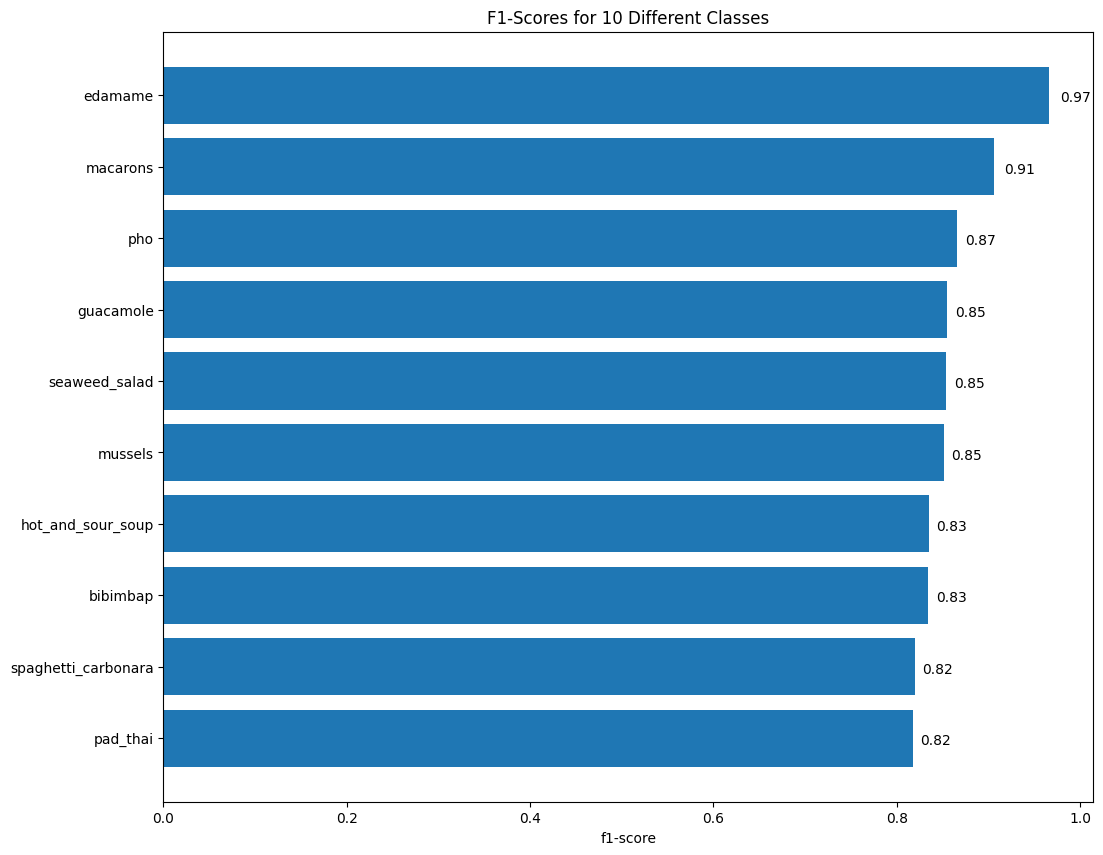

In [79]:
autolabelog(f1_scores[:10])

We can see the top performers are :

In [81]:
f1_scores[:10]

class_name  f1-score
33              edamame  0.966337
63             macarons  0.906445
75                  pho  0.865854
51            guacamole  0.854442
88        seaweed_salad  0.853503
65              mussels  0.851064
54    hot_and_sour_soup  0.834990
7              bibimbap  0.834331
91  spaghetti_carbonara  0.820144
70             pad_thai  0.817829

And the ones with lower detection ratio:

In [82]:
f1_scores[-10:]

class_name  f1-score
50  grilled_salmon  0.400000
37    filet_mignon  0.384444
15         ceviche  0.358621
99    tuna_tartare  0.334190
82         ravioli  0.319372
0        apple_pie  0.303297
77       pork_chop  0.293987
39       foie_gras  0.210210
87        scallops  0.186851
93           steak  0.157377

So we can see how `edamame` and `macarons`are being identified over 90% of the times, while `steaks`or `scallops`are going to be mistaken over 80% of the times.

If we want to visualize further, we have our `DisplayModelPredictions` functions to see how it goes. 



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


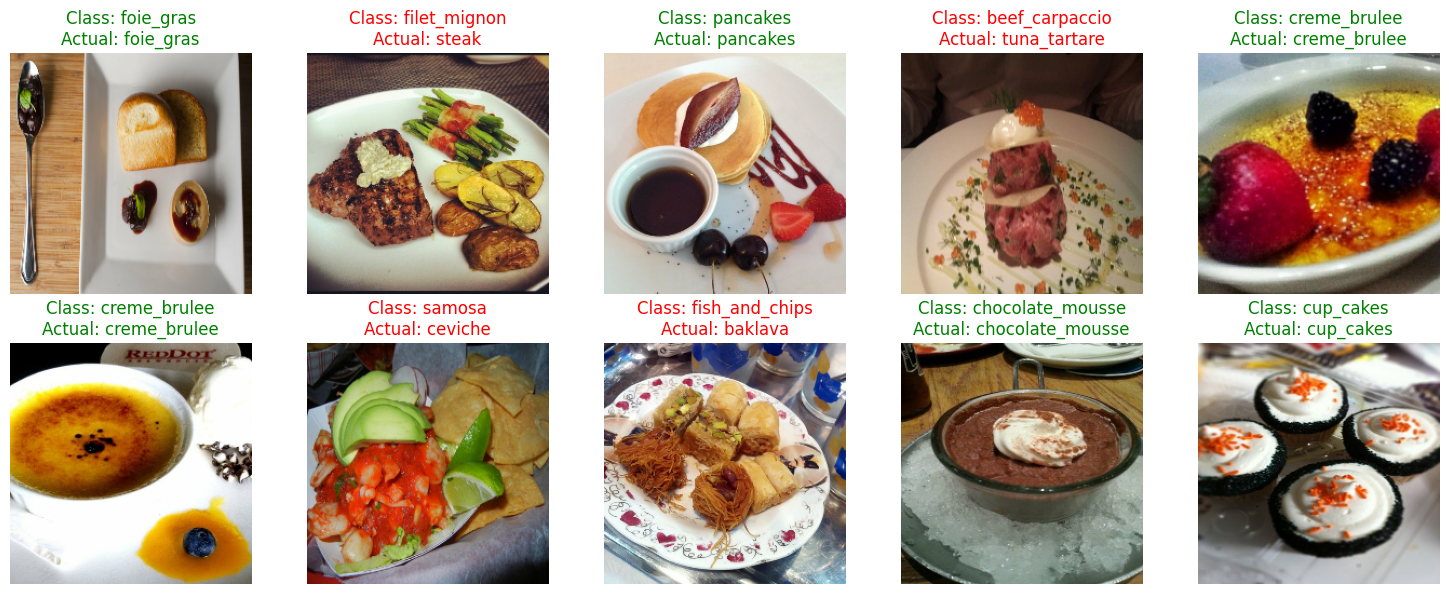

In [ ]:
modelgraph.DisplayModelPredictions(model_0_10p,test_10p_dataset,
                                   class_names,
                                   represented_images=10,
                                   batch=1)

Using our unshuffled dataset, we know that each batch contains 32 images. If we have 250 images per class and we want to visualize i.e. steaks, which is labeled in the position 93, that means we need to to go to the batch number 727 (250*93/32).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


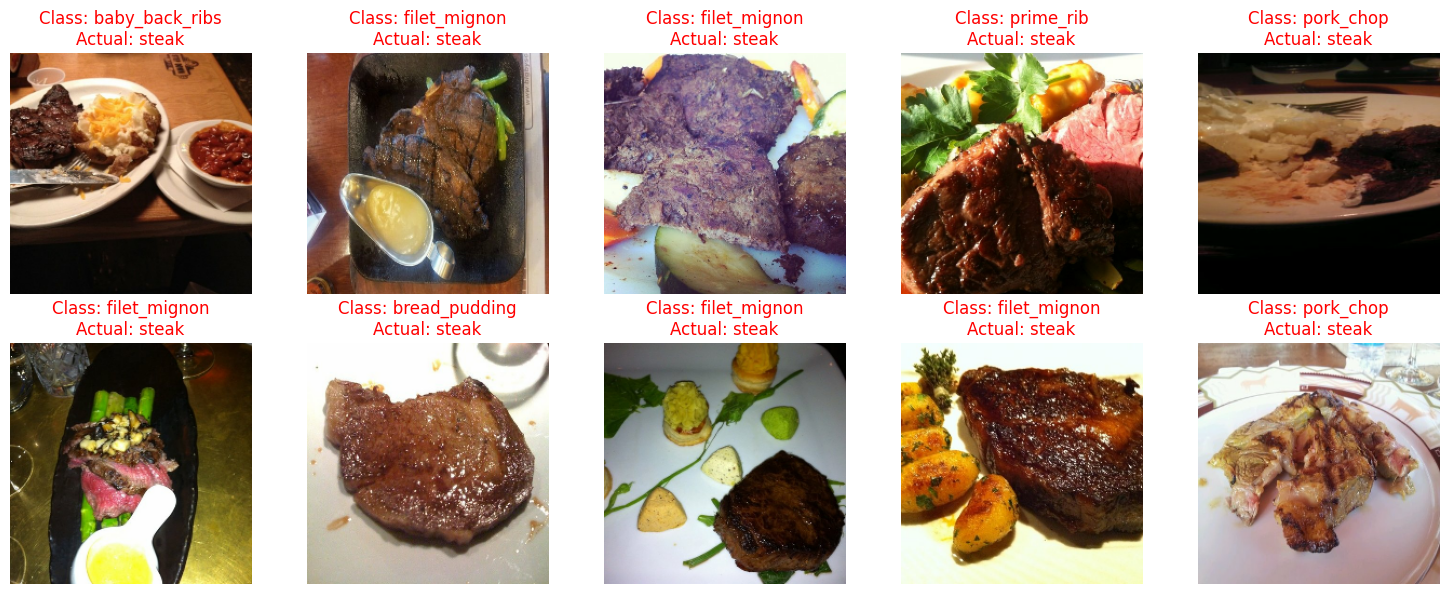

In [ ]:
modelgraph.DisplayModelPredictions(model_0_10p,test_10p_dataset_unshuffled,
                                   class_names,
                                   represented_images=10,
                                   batch=727)

Steak got classified as actual `steak` only 24 times, while it was classified as `filet mignon` 99 times. I think we can confirm this fact on this image seeing how many times it has been classified as that :)

To end, let's create a function to see the percentage of these missclassifications alonside with the `precision` of the classifications.

In [127]:
def compare_classifications(y_true, y_pred, class1_name, class2_name,class_names):
    """
    Compare classification results between two selected classes.

    Parameters:
    - y_true: List or Series of true labels.
    - y_pred: List or Series of predicted labels.
    - class1: The first class to compare.
    - class2: The second class to compare.

    Returns:
    - A dictionary showing the count of correct and incorrect classifications.
    """
    class1 = 999
    class2 = 999
    image_sets=250

    for i in range(len(class_names)):
        if class1_name==class_names[i]: class1=i
        if class2_name==class_names[i]: class2=i

    if class1==999 or class2==999:
        print("wrong class introduced")
        return

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({'True': y_true, 'Predicted': y_pred})
    
    # Filter only relevant classes
    df_filtered = df[df["True"].isin([class1, class2])]

    # Count correct classifications
    correct_class1 = ((df_filtered["True"] == class1) & (df_filtered["Predicted"] == class1)).sum()
    correct_class2 = ((df_filtered["True"] == class2) & (df_filtered["Predicted"] == class2)).sum()

    # Count misclassifications
    misclassified_as_class2 = ((df_filtered["True"] == class1) & (df_filtered["Predicted"] == class2)).sum()
    misclassified_as_class1 = ((df_filtered["True"] == class2) & (df_filtered["Predicted"] == class1)).sum()

   
    print(f"Correctly classified {class1_name}: {correct_class1} ({correct_class1*100/image_sets}%)")
    print(f"Correctly classified {class2_name}: {correct_class2} ({correct_class2*100/image_sets}%)")
    print(f"{class1_name} misclassified as {class2_name}: {misclassified_as_class2} ({misclassified_as_class2*100/image_sets}%)")
    print(f"{class2_name} misclassified as {class1_name}: {misclassified_as_class1} ({misclassified_as_class1*100/image_sets}%)")

In [128]:
compare_classifications(y_labels_unshuffled, pred_classes_unshuffled,'steak', 'filet_mignon',class_names)

Correctly classified steak: 24 (9.6%)
Correctly classified filet_mignon: 173 (69.2%)
steak misclassified as filet_mignon: 99 (39.6%)
filet_mignon misclassified as steak: 9 (3.6%)


We can confirm the correclty classified we have shown are the before shown recall values from the table ( true positives over the number of true positives and false negatives.)

In [134]:
class_recall['steak'],class_recall['filet_mignon'],

(0.096, 0.692)